In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
from pprint import pprint

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:////Users/yaden/Desktop/sqlalchemy-challenge/Resources/hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
Base = automap_base()

#reflect tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Listing column names 
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for name in columns:
    print(name['name'], name["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Listing column names 
inspector = inspect(engine)

columns = inspector.get_columns('station')
for name in columns:
    print(name['name'], name["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Example of date format in measurement table 
date_format = session.query(measurement.date).limit(5)
for result in date_format:
    print(result)


('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)


# Exploratory Climate Analysis

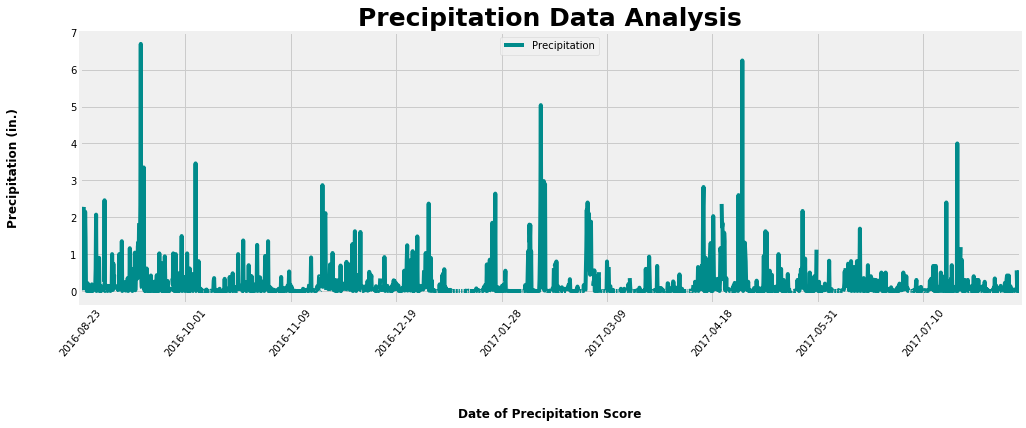

In [14]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = session.query(func.max(measurement.date)).all()
# print(one_year_ago)

# Database runs through August 23, 2017. 
# Need to filter date from same date one year ago

# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(measurement.date, measurement.prcp).filter(
        measurement.date >= "2016-08-23").\
        order_by(measurement.date).all()
# pprint(prcp_data[:10])

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp).order_by(
            measurement.date.desc()).all()

# pprint(scores[:5])


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=["Date", 'Precipitation'])
df.set_index("Date", inplace=True)
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))

df.plot(ax=ax, x_compat=True, figsize=(15,5), color='darkcyan')

plt.title("Precipitation Data Analysis", fontsize=25, weight='bold')
plt.legend(loc='upper center')
plt.xticks(rotation=50)
ax.set_ylabel('Precipitation (in.)', labelpad=50, weight='bold')
ax.set_xlabel('Date of Precipitation Score', labelpad=50, weight='bold')

plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(station.id).distinct().count()
print(f"There are {total_stations} stations total.")

There are 9 stations total.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(station.station, 
                              func.count(measurement.id)).select_from(measurement).\
                                join(station, measurement.station == station.station).group_by(station.station).\
                                order_by(func.count(measurement.id).desc()).all()

for result in station_count:
    print(f"Station: {result[0]} - Count: {result[1]}")

Station: USC00519281 - Count: 2772
Station: USC00519397 - Count: 2724
Station: USC00513117 - Count: 2709
Station: USC00519523 - Count: 2669
Station: USC00516128 - Count: 2612
Station: USC00514830 - Count: 2202
Station: USC00511918 - Count: 1979
Station: USC00517948 - Count: 1372
Station: USC00518838 - Count: 511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
active_station = 'USC00519281'

temps= session.query(func.min(measurement.tobs), func.max(measurement.tobs), 
                     func.avg(measurement.tobs)).filter(measurement.station == active_station).all()

# pprint(temps)

print(f"Lowest Temperature: {temps[0][0]}°F")
print(f"Highest Temperature: {temps[0][1]}°F")
print(f"Average Temperature: {round(temps[0][2], 1)}°F")

Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.7°F


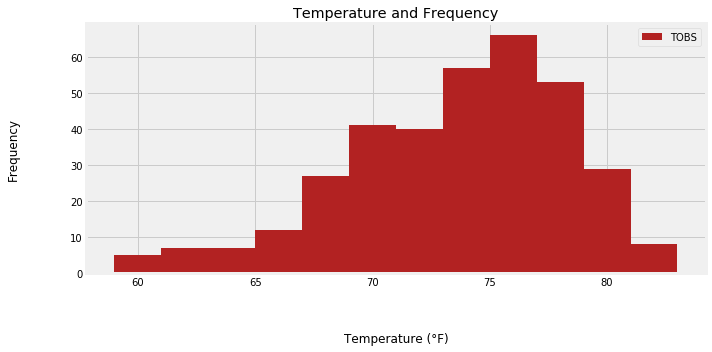

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs).\
                filter(measurement.date >= "2016-08-23").\
                filter(measurement.station == 'USC00519281').\
                order_by(measurement.date).all()

tobs_df = pd.DataFrame(tobs_data, columns=["TOBS"])

tobs_df.plot.hist(bins=12, title="Temperature and Frequency", figsize=(10,5), color='firebrick')
plt.xlabel("Temperature (°F)", labelpad=45)
plt.ylabel("Frequency", labelpad=50)


plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

# -------------------------------------------------------------------

#TMIN, TAVG, and TMAX for a list of dates.
    
#Args:
    #start_date (string): A date string in the format %Y-%m-%d
    #end_date (string): A date string in the format %Y-%m-%d
        
#Returns:
    #TMIN, TAVE, and TMAX
    
# -------------------------------------------------------------------

start_date = "2016-08-23"
end_date = "2017-08-23"

def calc_temps(start_date, end_date):
    return session.query(func.min(measurement.tobs), 
                         func.avg(measurement.tobs), 
                         func.max(measurement.tobs)).\
                        filter(measurement.date >= start_date).\
                        filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps(start_date, end_date))



my_trip = (calc_temps(start_date, end_date))

[(58.0, 74.59058295964125, 87.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Previous year and same date of trip is 2015-2016
# -------------------------------------------------------------------
# TMIN, TAVG, and TMAX for a list of dates.
    
# Args:
    # start_date (string): A date string in the format %Y-%m-%d
    # end_date (string): A date string in the format %Y-%m-%d
        
# Returns:
    # TMIN, TAVE, and TMAX

# -------------------------------------------------------------------

start_date = "2015-08-23"
end_date = "2016-08-23"

def calc_temps(start_date, end_date):
    return session.query(func.min(measurement.tobs), 
                         func.avg(measurement.tobs), 
                         func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps(start_date, end_date))



[(56.0, 74.45063829787235, 86.0)]


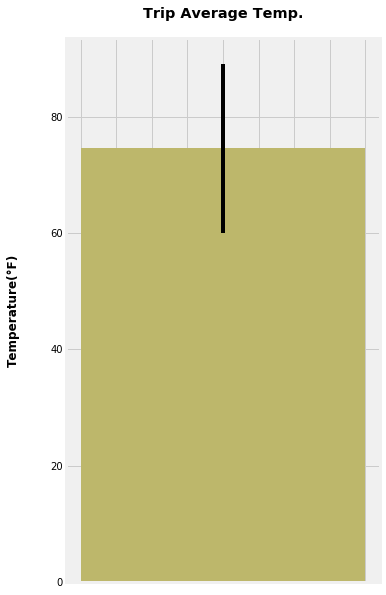

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = my_trip[0][2] - my_trip[0][0]
avg_temp = my_trip[0][1]

# Plotting figure
fig, temp_plot = plt.subplots(figsize = (5, 10))

temp_plot.bar(1, avg_temp, yerr = peak_to_peak/2, width= 0.4, color='darkkhaki')

# Setting labels
temp_plot.set_title('Trip Average Temp.', pad=20, weight='bold')
temp_plot.set_ylabel('Temperature(°F)', labelpad=30, weight='bold')


temp_plot.set_xticklabels([])

plt.show()

### Daily Rainfall Average

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = "2015-08-23"
end_date = "2016-08-23"

def rainfall(start_date, end_date):
    
    return session.query(measurement.station,
                        station.station,
                        station.name,
                        station.latitude, 
                        station.longitude,
                        station.elevation).\
                        group_by(measurement.station).\
                        join(station, measurement.station == station.station).\
                        filter(measurement.date >= start_date).\
                        filter(measurement.date <= end_date).\
                        order_by(func.sum(measurement.prcp).desc()).all()

rainfall(start_date, end_date)


[('USC00516128',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  'USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00511918',
  'USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 ('USC00518838',
  'USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6)]

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), 
           func.avg(measurement.tobs), 
           func.max(measurement.tobs)]
    return session.query(*sel).filter(
            func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("08-23")

daily_norm = daily_normals("08-23")
daily_norm

[(67.0, 76.6923076923077, 87.0)]

In [54]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

trip_dates = ["08-04", "08-05", "08-06", "08-07", "08-08",
              "08-09", "08-10", "08-11", "08-12", "08-13", 
              "08-14", "08-15", "08-16", "08-17", "08-18"]

# normals = []

# daily_normal = daily_norm(date)


    
#     sel = [func.min(measurement.tobs), 
#        func.avg(measurement.tobs), 
#        func.max(measurement.tobs)]

# final_dates = session.query((*sel).\
#                 filter(func.strftime('%m', measurement.date) == "08")).all()
#                 group_by(measurement.date)).all()
#                 order_by(measurement.date)).all()

# return session.query(*sel).filter(
#         func.strftime("%m-%d", measurement.date) == date).all()


date = f'2017-{trip_dates}'

def daily_normals(date):
    
    for date in trip_dates:
        
        sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
        
        return session.query((sel).filter(func.strftime("%m-%d", measurement.date)) == date).all()
    

#     day={}
    


    
#     results=session.query(measurement.date, 
#                           func.max(measurement.tobs),
#                           func.min(measurement.tobs),
#                           func.avg(measurement.tobs).filter(measurement.date==f'2017-{date}')).first()
    

#     results=session.query((measurement.date,\
#                          func.max(measurement.tobs),\
#                          func.min(measurement.tobs),\
#                           func.avg(measurement.tobs)))\
#                             .filter(measurement.date==date)\
                          #  .group_by(measurement.date).all()
                          #filter(('month', measurement.date) == "08").\
                          #filter(('day', measurement.date) == date)).first()
#                           group_by(measurement.date).\
#                           order_by(measurement.date)).all()


#     for res in results:
#         print(res)

 #   break
        
        
print(daily_normals)

# daily_normal = norms
# daily_normal

<function daily_normals at 0x7fb73331f5f0>


In [139]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(daily_normal)
normal_df

,Date,Min,Avg,Max
0,2017-08-04,70.0,76.923077,84.0
1,2017-08-05,70.0,76.923077,84.0
2,2017-08-06,70.0,76.923077,84.0
3,2017-08-07,70.0,76.923077,84.0
4,2017-08-08,70.0,76.923077,84.0
5,2017-08-09,70.0,76.923077,84.0
6,2017-08-10,70.0,76.923077,84.0
7,2017-08-11,70.0,76.923077,84.0
8,2017-08-12,70.0,76.923077,84.0
9,2017-08-13,70.0,76.923077,84.0


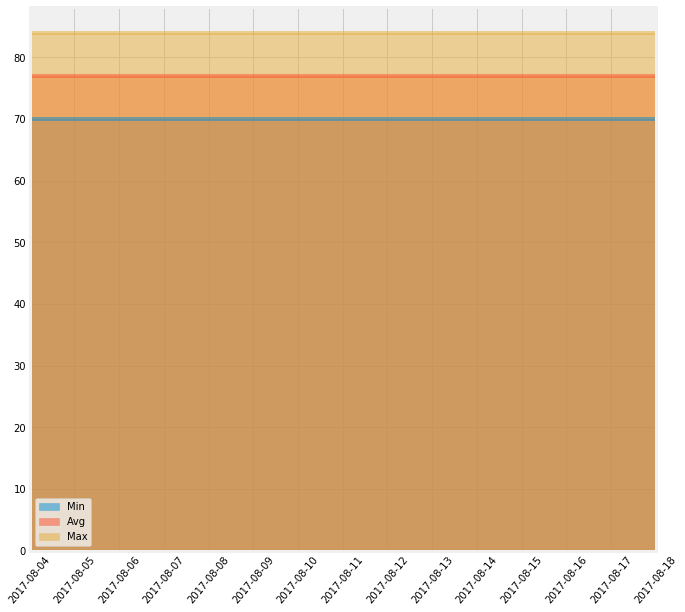

In [144]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,10))
normal_df.plot.area(ax=ax, stacked= False)

dates = [f"2017-{date}" for date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation=50)

plt.show()


In [ ]:
# Save references to each table


In [ ]:
# Create our session (link) from Python to the DB
